# Guided Exploration - Infer MITRE technique from Threat Intel Data

__Notebook Version:__ 1.0<br>

__Notebook Author:__ Vani Asawa<br>

__Python Version:__ >=Python 3.8<br>

__Platforms Supported:__  Azure Machine Learning Notebooks

__Data Source Required:__ No<br>

__Data Source:__ None<br>

__GPU Compute Required:__ No<br>

__GPU Compute Recommended:__ Yes<br>

__Requirements Path:__ ```Guided Exploration - Infer MITRE technique from Threat Intel Data/requirements.txt```<br>

## Description
**Cyber Threat Intelligence** (CTI) provides a framework for threat analysts to document the operations of a threat actor group and record the findings of their investigations of specific cyber attack incidents.

With the increasing number and sophistication of attacks occuring across organization's workspace CTI allows organisations to develop a more robust and proactive security posture better detect threat vulnerabilities in their infrastructre and adopt security solutions and policies that allow them to better protect their environment. For example **Indicators of Compromise (IoC)** represent network artifacts of a cyber intrusion and are widely used in intrusion detection systems and antivirus softwares to detect future attacks.

**Threat Intel Data** is another form of CTI which comprises of rich unstructured textual data describing the tools techniques and procedures used by threat actor groups in a cyber operation. Historically TI data is made available to the security community in the form of blog posts reports and white papers. With the increasing numebr of cyber attacks it is not scalable to manually process this growing corpus of TI data to understand the motivations capabilities and TTPs associated with an actor group. Additionally TI data does not facilitate easy extraction of IoCs which if documented in the report can result in the loss of known indicators in the threat intelligence corpus. This opens up several avenues for **Machine Learning** more particularly **Natural Language Processing** (NLP) to identify TTPs and IoCs from this data.

The **MITRE ATT&CK** framework is an openly-sourced knowledge base of TTPs used by adversaries across enterprise and mobile applications. MITRE TTPs allow people and organizations to proactively identify vulnerabilites in their system based on the behaviors methods and patterns of activity used by an actor group in different stages of a cyber operation.
       
***In this notebook we use NLP to
1. *Detect MITRE TTPs* &
2. *Extract IoCs*

from unstructured English text-based Threat Intel data. We also provide some explainability into the TTP predictions made by our NLP model by identifying specific words or phrases in the input TI data that contribute to the prediction.***

## Prerequisites
**Please do not run the notebook cells all at once**. The cells need to be run sequentially and successfully executed before proceeding with the remainder of the notebook.

## Table of Contents

1. Imports
2. Configure Input Data and Model Parameters
3. Get Model Artifacts
4. Process TI Data
5. Inference
6. Explainability

## Installations

Please download the packages in ```Guided Exploration - Infer MITRE technique from Threat Intel Data/requirements.txt``` in your virtual environment before running the rest of the cells in the notebook.

In [1]:
import os
import sys
sys.path.append(os.getcwd())

############### REQUIREMENTS.TXT NEEDS TO BE UPDATED ################
# requirements_path = os.path.join(os.getcwd() 'requirements.txt')
# os.system(fpip install -r {requirements_path})

##  Imports

The modules used to run this notebook can be found under ```Guided Exploration - Infer MITRE technique from Threat Intel Data/utils/*```

In [2]:
import torch
import utils
from utils import (
    configs as config_utils,
    storage as storage_utils,
    inference as inference_utils,
    process as process_utils,
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaasawa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vaasawa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vaasawa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vaasawa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Configure Input Data and Model Parameters,
The notebook requires the following parameters from the user:
1. ***Threat Intel Data***: Unstructured, English text data that the user would like to process through the NLP model. If you are inputting multiple text reports in the widget, please input the reports separated by an empty line. Do not include any commas, punctuations, or brackets before and after the reports. <br>
- For example: Here, we are processing three different threat reports, which are separated by an empty line. The length of each report can be more than one sentence. In this example, for the purposes of succinct documentation, the length of each report is 1 sentence.

    ```
    Like many threat groups, TG-3390 conducts strategic web compromises (SWCs), also known as watering hole attacks, on websites associated with the target organization's vertical or demographic to increase the likelihood of finding victims with relevant information.

    Threat groups use strategic web compromises (SWCs), also known as watering hole attacks, to target a wide array of potential victims.

    A build tool is likely being used by these attackers that allows the operator to configure details such as C2 addresses, C2 encryption keys, and a campaign code.
    ```
       
2. ***Select NLP Model***: We have trained four variations of GPT-2 transformer models using publicly-available threat intel datasets that map TI data to MITRE TTPs. 
- *distilgpt2* models are 40% lower in storage size than the *gpt2* models <br>

- *distilgpt2-1024* and *gpt2-1024* models process more word tokens in a single threat input statement than the *distilgpt2-512* and *distilgpt2-1024* models, which can be particularly useful if your threat intel data is long. <br>

- Default model: **distilgpt2_512** <br><br>

3. ***Minimum Score Threshold***: The TTP predictions for a sample TI input data have an associated confidence score from the NLP model, ranging from 0 (less confident) to 1 (most confident). Filter the results to predictions with confidence >= threshold configured by the user. <br>

- Default threshold: **0.7** <br> <br>
       
4. ***Chunk Threat Intel Data?***: 
- One of the limitations of the transformer models is that they can only process inputs upto a certain length, after which the rest of the report is discarded. 
- As a result, the model will lose out on potentially important information about the actor's TTPs, described in the latter parts of the report. 
- If a single threat report in your input is longer than 3 sentences, we recommend **chunking** - The model will process the sentences in your input data in batches of 3 sentences, hence assigning a TTP prediction for each chunk of data, and processing the entire report. <br>

- Default value: **Yes** <br><br>

5. ***Extract Indicators of Compromise (IoCs)***: Extract IoCs from the input TI data. <br>

- Default value: **Yes** <br><br>

6. ***Get NLP Model Explainability***: Obtain further insights into which words and phrases in your input data contributed to the TTP prediction. <br>

- Default value: **Yes** <br><br>

In [3]:
all_config_widgets = config_utils.configure_model_parameters()
for k in all_config_widgets.keys():
       display(all_config_widgets[k])

Textarea(value='', description='Threat Intel Data:', layout=Layout(height='200px', width='80%'), style=Descrip…

Select(description='Select NLP Model: ', layout=Layout(height='80px', width='50%'), options=('distilgpt2-512',…

FloatSlider(value=0.7, description='Minimum Score Threshold: ', layout=Layout(height='30px', width='50%'), max…

Select(description='Chunk Threat Intel data?: ', layout=Layout(height='80px', width='50%'), options=('Yes', 'N…

Select(description='Extract Indicators Of Compromise (IoCs)?: ', layout=Layout(height='80px', width='50%'), op…

Select(description='Get NLP Model Explainability?: ', layout=Layout(height='80px', width='50%'), options=('Yes…

In [13]:
set_configs = {
    k: v.value for k, v in all_config_widgets.items()
}

configs = config_utils.format_user_configuration(set_configs, verbose=True)

#################### SUMMARY #################### 

Threat Intel (TI) Data: [

	"Like many threat groups, TG-3390 conducts strategic web compromises (SWCs), also known as watering hole attacks, on websites associated with the target organization's vertical or demographic to increase the likelihood of finding victims with relevant information.", 

	"Threat groups use strategic web compromises (SWCs), also known as watering hole attacks, to target a wide array of potential victims.", 

	"A build tool is likely being used by these attackers that allows the operator to configure details such as C2 addresses, C2 encryption keys, and a campaign code."

]

# of TI entries: 3

NLP Model: distilgpt2-512

Minimum Score Threshold: 0.0

Chunk Threat Intel data?: Yes

Extract Indicators Of Compromise (IoCs)?: Yes

Get NLP Model Explainability?: Yes

################################################# 



## Get Model Artifacts

In [5]:
asset_storage = storage_utils.AssetStorage(
    configs['model']
)

model = asset_storage.model
tokenizer = asset_storage.tokenizer
device = asset_storage.device
labels = asset_storage.labels

Tokenizer artifact obtained from path c:\Users\vaasawa\Documents\GitHub\msticpy-data\Guided Investigation - Infer MITRE technique from Threat Intel Data\artifacts\distilgpt2-512\tokenizer
Labels artifact obtained from path c:\Users\vaasawa\Documents\GitHub\msticpy-data\Guided Investigation - Infer MITRE technique from Threat Intel Data\artifacts\distilgpt2-512\labels


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model artifact obtained from path c:\Users\vaasawa\Documents\GitHub\msticpy-data\Guided Investigation - Infer MITRE technique from Threat Intel Data\artifacts\distilgpt2-512\model_state_dicts
Model on device 'cpu'


In [14]:
inference_model = inference_utils.InferenceClassificationPipeline(
    model = model,
    tokenizer = tokenizer,
    device = device.type
)

## Process TI Data

In [15]:
processed_data_object = process_utils.ProcessData(
    configs = configs
)

processed_data_object.go()

## Inference

In [16]:
outputs = inference_model.go(processed_data_object.processed_data)

In [17]:
inference_df = inference_utils.format_predictions(
    configs = configs,
    processed_data_object = processed_data_object,
    labels = labels,
    outputs = outputs,
    classifier = inference_model.classifier_max_scores
)

Partition explainer: 2it [00:32, 32.39s/it]               
Partition explainer: 2it [00:20, 20.43s/it]               


In [18]:
print(f'Shape of DF: {inference_df.shape}')
       
print('Sample Result: ')
if inference_df.empty:
    print('Empty Dataframe')
else:
    display(inference_df.head(1))

Shape of DF: (3, 11)
Sample Result: 


,threat_intel,processed_threat_intel,flag_chunk,num_chunks,flag_iocs,iocs,output,model,flag_explain,shap_base,shap_contribution
0,"Like many threat groups, TG-3390 conducts stra...","[like many threat group , alphanumeric_token c...",True,1,True,"[{'IP': [], 'EMAIL': [], 'URL': [], 'YARA': []...","[{'label': 'LABEL_78', 'score': 0.277480393648...",distilgpt2-512,True,"[{'values': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[{'positive': {}, 'neutral': {'like': 0.0, 'ma..."


## Explainability - Visualisation

Inference Dataframe row index: 2 

Threat Intel Data: 

A build tool is likely being used by these attackers that allows the operator to configure details such as C2 addresses, C2 encryption keys, and a campaign code.

Chunk #1 

Processed Data: 
build tool likely used attacker allows operator configure detail alphanumeric_token address , alphanumeric_token encryption key , campaign code .

Predicted Label: 
{'label': 'LABEL_73', 'score': 0.34701430797576904, 'technique': 'T1140', 'chunk': 1}

Shap Legend: {Red: Positive Contribution to Predicted Label, Blue: Negative Contribution to Predicted Label} 

Shap Bar Plot: 


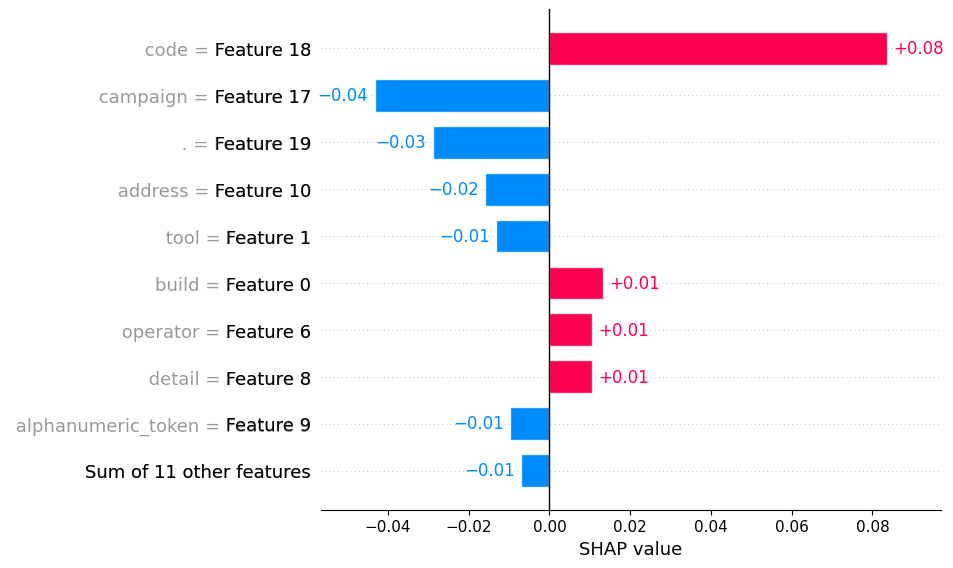

Shap Text Plot: 


In [19]:
row_index = 2
       
inference_utils = inference_utils.process_shap_explainability_for_row(
    inference_df, row_index
)